In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
from numpy.linalg import norm, matmul
mpl.rcParams['axes.linewidth'] = 1.2
from numpy.linalg import norm
#from numba import njit
#from numba.experimental import jitclass
from scipy.interpolate import RegularGridInterpolator, interp1d
#import pycharge as pc
pycharge_flag=1
c = 3E8
f_res = 2.856e9
Amp_fac=0.12
phi_RF = 0 #np.pi
omega = 2*np.pi*f_res

#space charge solver
import spacecharger as sc
import fourvectors as fv

EPSILON_0 = 8.85E-12
COULOMB_K = 1 / (4 * np.pi * EPSILON_0)

In [2]:
class Particle():
    def __init__(self,q,m,vel,pos):
        self.q = q
        self.m = m
        self.vel = vel
        self.pos = pos
        self.Efld = np.zeros(3)
        self.Efld_r = np.zeros(3)
        self.Bfld = np.zeros(3)
        self.Bfld_r = np.zeros(3)
        self.theta = 0
        self.r = 0
        self.tlost = 0
        self.tsteplost = 0
        self.isLost = False

    def set_fields(self,Efld,Bfld):
        self.Bfld = Bfld
        self.Efld = Efld

    def Boris(self,dt):
        Uprime = np.zeros(3)
        gmma = 1.0/np.sqrt(1-norm(self.vel)**2/c**2)
        const1 = dt*self.q/(2*self.m)
        Upast = gmma*self.vel
        Uminus = Upast + const1*self.Efld
        gmma_new = np.sqrt(1 + norm(Uminus)**2/c**2)
        t = self.Bfld*const1/gmma_new
        Uprime = Uminus + np.cross(Uminus,t)
        Uplus = Uminus + np.cross(Uprime,2*t/(1+norm(t)**2))
        Unext = Uplus + const1*self.Efld
        self.vel = Unext/np.sqrt(1+norm(Unext)**2/c**2)
        self.pos = self.pos + dt*self.vel
        return self.pos,self.vel


def convert_particle_to_relativistic(part):
    """
    Stupid hack to convert a Particle instance to RelativisticBunchParticle
    """

    rpart = RelativisticBunchParticle(
        pos3=part.pos,
        vel3=part.vel,
        mass=part.m,
        charge=part.q
    )

    #transfer everything else
    rpart.Efld = part.Efld
    rpart.Bfld = part.Bfld
    rpart.Efld_r = part.Efld_r
    rpart.Bfld_r = part.Bfld_r
    rpart.theta = part.theta
    rpart.r = part.r
    rpart.tlost = part.tlost
    rpart.tsteplost = part.tsteplost
    rpart.isLost = part.isLost

    return rpart

class RelativisticBunchParticle(Particle):
    def __init__(
        self,
        pos3=None,       # 3-position
        vel3=None,       # 3-velocity
        mass=None,
        charge=None):

        if pos3 is None or vel3 is None or mass is None or charge is None:
            print(f"POS3: {pos3}")
            print(f"VEL3: {vel3}")
            print(f"MASS: {mass}")
            print(f"CHRG: {charge}")
            raise ValueError("Non-Physical Particle. If this prints, something else is fundamentally wrong.")

        ### Initialize the base Particle
        super().__init__(q=charge, m=mass, vel=vel3, pos=pos3)

        ### Store the extra relativity attributes
        self.pos4 = fv.to_four_position(pos3, 0.0)
        self.vel4 = fv.to_four_velocity(vel3)

        # Assume that all particles are not the reference. I set the reference particle flag later
        self.is_ref = False

    def set_reference(self):
        self.is_ref = True

    ### Lorentz Boost Functionality
    def lorentz_boost_to(self, other):
        """Lorentz boost to another particle's frame"""
        print("before", self.pos4, other.pos4)
        
        lorentz_matrix = fv.lorentz_matrix_z_4v(other.vel4)
        self.vel4 = matmul(lorentz_matrix, self.vel4)
        
        if self.is_ref:
            self.pos4 = np.zeros(4)
        else:
            self.pos4 = matmul(
                lorentz_matrix,
                (self.pos4 - other.pos4)
            )

        
        print("after", self.pos4, other.pos4)
        
        # then update the other velociites
        self.vel = fv.to_three_velocity(self.vel4)
        print("fuh", fv.to_three_position(self.pos4)[0])
        self.pos = fv.to_three_position(self.pos4)[0]

    def boost_as_reference(self):
        self.lorentz_boost_to(self)

    ### Getters
    def get_3v(self):
        return fv.to_three_velocity(self.vel4)

    def get_3p(self):
        return fv.to_three_position(self.pos4)

In [3]:
Npart = 5 # number of particles
Nt = 75
spotsize = 5e-4  # spot size, like rad of bunch
bunchLength = 3.2e-5
velz = 1.46717e-03 #initial
parts = np.zeros([Npart,6])

parts[0] = np.array([0,0,0,0,-bunchLength/2,velz])
for i in range(1,Npart):
    parts[i,-2] = np.random.uniform(low=-bunchLength,high=0)
    parts[i,-1] = velz
    x = np.random.uniform(low=-spotsize/2,high=spotsize/2)
    y = np.random.uniform(low=-spotsize/2,high=spotsize/2)
    if (np.sqrt(x**2 + y**2) < spotsize/2):
        parts[i,0] = x
        parts[i,2] = y #r*np.sin(th)

np.savetxt('partcl.data', parts)
partsIMP = np.loadtxt("partcl.data")

#start_overall = time.time()
#for k in range(len(charges)):
#print("Analysing ", charges[k], "nC")
vel = np.zeros([len(partsIMP),Nt,3])
pos = np.zeros([len(partsIMP),Nt,3])
parts = []
Np = len(partsIMP)

q = 1.6e-19
me = 9.1e-31
chargenC = 10
beamCharge = -1e-9*chargenC
Ibeam = 1.3*chargenC

p_charge = beamCharge/Np
p_mass = abs(p_charge/q)*me

for i in range(len(partsIMP)):
    vel[i,0,0] = partsIMP[i,1]
    vel[i,0,1] = partsIMP[i,3]
    vel[i,0,2] = 2.5e8 #partsIMP[i,5]
    pos[i,0,0] = partsIMP[i,0]
    pos[i,0,1] = partsIMP[i,2]
    pos[i,0,2] = partsIMP[i,4]
    parts.append(Particle(p_charge,p_mass,vel[i,0],pos[i,0]))

In [4]:
rel_parts = [
    convert_particle_to_relativistic(p)
    for p in parts
]

# set the first particle to be the reference particle
rel_parts[0].set_reference()
ref_part = rel_parts[0]

before [-3.49697763e-04 -1.02264686e-05 -7.67773574e-06  3.56534601e-04] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
after [-1.19424410e-03 -1.02264686e-05 -7.67773574e-06  1.20112966e-03] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
fuh [-1.02264686e-05 -7.67773574e-06  1.20112966e-03]
before [-3.08731839e-03  7.79042617e-05  1.16951097e-04  3.09418923e-03] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
after [-1.02739558e-02  7.79042617e-05  1.16951097e-04  1.02808516e-02] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
fuh [7.79042617e-05 1.16951097e-04 1.02808516e-02]
before [ 0.00072471  0.          0.         -0.00071789] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
after [ 0.0023692   0.          0.         -0.00236231] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
fuh [ 0.          0.         -0.00236231]
before [-8.75445806e-04  1.79742709e-04  2.04066916e-06  8.82289173e-04] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
after [-2.93796293e-03  1.79742709e-04  2.04066916e-06  2.94485047e-03] [ 0.0e+00  0.0e+00  0.0e+00 -1.6e-05]
f

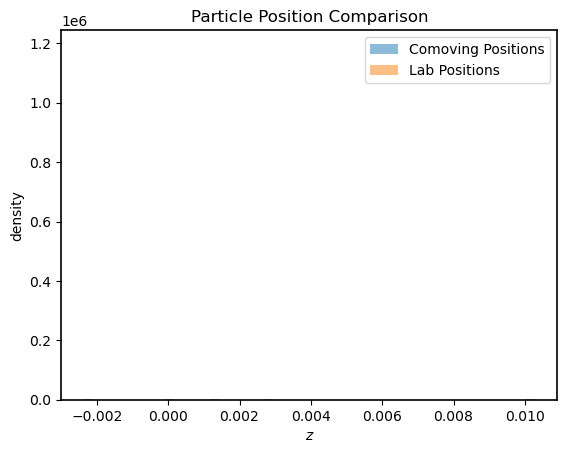

In [10]:
###
# STEP 2: Lorentz boost to the reference particle's frame
###

def plotNormalWithLine(s, sig=None, mu=None, title=None, opacity=None):
    _, bins, _ = plt.hist(s, 50, density=True, label = title, alpha = opacity)

    if sig is not None and mu is not None:
        plt.plot(bins, 1/(sig * np.sqrt(2 * np.pi)) *
                    np.exp( - (bins - mu)**2 / (2 * sig**2) ),
                linewidth=2, color='r')

# Perform the lorentz boost for each non-reference particle
for particle in rel_parts:
    if particle.is_ref == True:
        continue
    particle.lorentz_boost_to(ref_part)
# we are now in the co-moving frame

# get the velocities and positions of each particle
lab_particle_pos = np.array([particle.pos for particle in parts])
com_particle_pos = np.array([particle.pos for particle in rel_parts])


print(lab_particle_pos[:])
print(com_particle_pos[:])

plt.xlabel("$z$")
plt.ylabel("density")
plotNormalWithLine(com_particle_pos[:,2], title="Comoving Positions", opacity = 0.5)
plotNormalWithLine(lab_particle_pos[: 2], title="Lab Positions", opacity =0.5)
plt.legend()
plt.title("Particle Position Comparison")
plt.show()